# Script para determinar el número de arranques de las undiades y el estado térmico

In [1]:
# Library import

import warnings

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import pandas as pd
from pathlib import Path
import datetime as dt
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from google.cloud import bigquery
from google.oauth2 import service_account

delta=dt.timedelta(days=1)

In [2]:
# Leer archivo de excel
s_parentpath=Path('C:\Alejo\ExtracciónDatos')
filepath=s_parentpath.joinpath(s_parentpath,'DataUnidadesSIO2024_2025.xlsx')

# Loas units
sheet_name='Data'
df_dataU=pd.read_excel(filepath, header=0,sheet_name=sheet_name)

In [3]:
Uniades=df_dataU['Elemento'].unique()
df_unidades = pd.DataFrame({'unidad': Uniades})
df_unidades[['caliente', 'tibio']] = np.nan

df_unidades.loc[df_unidades["unidad"] == "TERMOCANDELARIA CC 1", "caliente"] = 8
df_unidades.loc[df_unidades["unidad"] == "TERMOCANDELARIA CC 2", "caliente"] = 8
df_unidades.loc[df_unidades["unidad"] == "TERMOCANDELARIA CC 3", "caliente"] = 8

df_unidades.loc[df_unidades["unidad"] == "TERMOCANDELARIA CC 1", "tibio"] = 72
df_unidades.loc[df_unidades["unidad"] == "TERMOCANDELARIA CC 2", "tibio"] = 72
df_unidades.loc[df_unidades["unidad"] == "TERMOCANDELARIA CC 3", "tibio"] = 72

df_unidades.loc[df_unidades["unidad"] == "TEBSA 11", "caliente"] = 24
df_unidades.loc[df_unidades["unidad"] == "TEBSA 12", "caliente"] = 24
df_unidades.loc[df_unidades["unidad"] == "TEBSA 13", "caliente"] = 24
df_unidades.loc[df_unidades["unidad"] == "TEBSA 21", "caliente"] = 24
df_unidades.loc[df_unidades["unidad"] == "TEBSA 22", "caliente"] = 24
df_unidades.loc[df_unidades["unidad"] == "TEBSA 14", "caliente"] = 24
df_unidades.loc[df_unidades["unidad"] == "TEBSA 24", "caliente"] = 24

df_unidades.loc[df_unidades["unidad"] == "TEBSA 11", "tibio"] = 36
df_unidades.loc[df_unidades["unidad"] == "TEBSA 12", "tibio"] = 36
df_unidades.loc[df_unidades["unidad"] == "TEBSA 13", "tibio"] = 36
df_unidades.loc[df_unidades["unidad"] == "TEBSA 21", "tibio"] = 36
df_unidades.loc[df_unidades["unidad"] == "TEBSA 22", "tibio"] = 36
df_unidades.loc[df_unidades["unidad"] == "TEBSA 14", "tibio"] = 36
df_unidades.loc[df_unidades["unidad"] == "TEBSA 24", "tibio"] = 36


df_unidades.loc[df_unidades["unidad"] == "BARRANQUILLA 3", "caliente"] = 7
df_unidades.loc[df_unidades["unidad"] == "BARRANQUILLA 4", "caliente"] = 8

df_unidades.loc[df_unidades["unidad"] == "BARRANQUILLA 3", "tibio"] = 24
df_unidades.loc[df_unidades["unidad"] == "BARRANQUILLA 4", "tibio"] = 24

df_unidades

,unidad,caliente,tibio
0,TERMOCANDELARIA CC 3,8.0,72.0
1,TERMOCANDELARIA CC 1,8.0,72.0
2,TERMOCANDELARIA CC 2,8.0,72.0
3,TEBSA 13,24.0,36.0
4,TEBSA 21,24.0,36.0
5,TEBSA 14,24.0,36.0
6,TEBSA 12,24.0,36.0
7,TEBSA 11,24.0,36.0
8,TEBSA 22,24.0,36.0
9,TEBSA 24,24.0,36.0


In [4]:
df_dataU

,Acción,Tipo de elemento,Elemento,Tiempo de ocurrencia,Agente,Detalle,Pre-autorizada,Origen Acción,Causa detallada CNO,Combustible,Estado térmico,Configuración,Descripción
0,Fuera de Servicio,UnidadTermica,TERMOCANDELARIA CC 3,01/01/2024 04:12,TERMOCANDELARIA S.C.A. - E.S.P.,Instrucción CND,Si,Instrucción CND,NaN,Gas,NaN,NaN,Sale por operación
1,Fuera de Servicio,UnidadTermica,TERMOCANDELARIA CC 1,01/01/2024 04:26,TERMOCANDELARIA S.C.A. - E.S.P.,Instrucción CND,Si,Instrucción CND,NaN,Gas,NaN,NaN,Ingresar Descripción:Sale por operación
2,Fuera de Servicio,UnidadTermica,TERMOCANDELARIA CC 2,01/01/2024 05:27,TERMOCANDELARIA S.C.A. - E.S.P.,Instrucción CND,Si,Instrucción CND,NaN,Gas,NaN,NaN,Sale por operación
3,En Servicio,UnidadTermica,TEBSA 13,02/01/2024 05:45,TERMOBARRANQUILLA S.A. EMPRESA DE SERVICIOS PU...,Instrucción CND,Si,Instrucción CND,Otros - origen no forzado,Gas,NaN,NaN,Entra en operación.
4,En Servicio,UnidadTermica,TEBSA 21,02/01/2024 07:00,TERMOBARRANQUILLA S.A. EMPRESA DE SERVICIOS PU...,Instrucción CND,Si,Instrucción CND,Otros - origen no forzado,Gas,NaN,NaN,Entra en operación
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5652,Fuera de Servicio,UnidadTermica,TEBSA 11,21/12/2025 08:00,TERMOBARRANQUILLA S.A. EMPRESA DE SERVICIOS PU...,Instrucción CND,No,Instrucción CND,NaN,Gas,NaN,NaN,NaN
5653,En Servicio,UnidadTermica,TERMOCANDELARIA CC 2,21/12/2025 12:02,TERMOCANDELARIA S.A.S. - E.S.P.,Instrucción CND,No,Instrucción CND,NaN,Gas,Tibio,4.0,NaN
5654,En Servicio,UnidadTermica,TEBSA 13,21/12/2025 13:58,TERMOBARRANQUILLA S.A. EMPRESA DE SERVICIOS PU...,Instrucción CND,No,Instrucción CND,NaN,Gas,Caliente,4.0,NaN
5655,En Servicio,UnidadTermica,TERMOCANDELARIA CC 3,21/12/2025 14:05,TERMOCANDELARIA S.A.S. - E.S.P.,Instrucción CND,No,Instrucción CND,NaN,Gas,Tibio,4.0,NaN


In [5]:
df_dataU['Acción'].unique()

array(['Fuera de Servicio', 'En Servicio', 'Cambio de disponibilidad',
       'Indisponible', 'Disponible'], dtype=object)

## Paso 1 — Preparar los datos

In [6]:
import pandas as pd

# Copias limpias
df_evt = df_dataU.copy()
df_units = df_unidades.copy()


df_evt["Tiempo de ocurrencia"] = pd.to_datetime(
    df_evt["Tiempo de ocurrencia"],
    format="%d/%m/%Y %H:%M"
)

# Timestamps
df_evt["Tiempo de ocurrencia"] = pd.to_datetime(df_evt["Tiempo de ocurrencia"])

# Orden cronológico
df_evt = df_evt.sort_values(["Elemento", "Tiempo de ocurrencia"])


## Paso 2 — Función de análisis por unidad

In [7]:
import pandas as pd
import numpy as np

def analizar_unidad(df_u, params):
    """
    df_u : eventos de UNA unidad, con:
           - "Acción"
           - "Tiempo de ocurrencia"
    params : fila de df_unidades con columnas: "caliente", "tibio"
    """

    caliente_h = float(params["caliente"])
    tibio_h    = float(params["tibio"])

    # Nos quedamos SOLO con los dos estados relevantes
    eventos = (
        df_u.sort_values("Tiempo de ocurrencia")
            .reset_index(drop=True)
            .copy()
    )
    eventos["Acción"] = eventos["Acción"].astype(str).str.strip()
    eventos = eventos[eventos["Acción"].isin(["En Servicio", "Fuera de Servicio"])].copy()

    # Si queda vacío o con muy pocos eventos, retorna ceros
    if eventos.empty:
        return pd.Series({
            "arranques_totales": 0,
            "arranques_caliente": 0,
            "arranques_tibio": 0,
            "arranques_frio": 0,
            "horas_operacion": 0.0
        })

    # Opcional: eliminar repeticiones consecutivas del mismo estado (ruido)
    eventos["Accion_prev"] = eventos["Acción"].shift(1)
    eventos = eventos[eventos["Acción"] != eventos["Accion_prev"]].copy()
    eventos = eventos.reset_index(drop=True)

    t = eventos["Tiempo de ocurrencia"]

    # === Lógica robusta para "salida real" (FDS que cierra un En Servicio previo) ===
    # last_on_time: último timestamp donde hubo "En Servicio" (ffill)
    last_on_time  = t.where(eventos["Acción"] == "En Servicio").ffill()

    # last_off_time: último timestamp donde hubo "Fuera de Servicio" (ffill)
    last_off_time = t.where(eventos["Acción"] == "Fuera de Servicio").ffill()

    # Fuera de Servicio es salida real si:
    # - existe un En Servicio previo (last_on_time notna)
    # - y ese En Servicio es más reciente que el último Fuera de Servicio previo (no "cerrado")
    prev_off = last_off_time.shift(1)
    eventos["es_salida_real"] = (
        (eventos["Acción"] == "Fuera de Servicio") &
        last_on_time.notna() &
        (prev_off.isna() | (last_on_time > prev_off))
    )

    # Índices de arranques y de salidas reales
    idx_arranques = eventos.index[eventos["Acción"] == "En Servicio"].to_list()
    idx_salidas   = eventos.index[eventos["es_salida_real"]].to_list()

    arranques = len(idx_arranques)
    caliente = tibio = frio = 0
    horas_operacion = 0.0

    for i in idx_arranques:
        t_start = eventos.loc[i, "Tiempo de ocurrencia"]

        # 1) Clasificación térmica:
        #    Tomamos la última salida real ANTES del arranque
        prev_salidas = [j for j in idx_salidas if j < i]
        if prev_salidas:
            j_prev = prev_salidas[-1]
            t_out = eventos.loc[j_prev, "Tiempo de ocurrencia"]
            horas_fuera = (t_start - t_out).total_seconds() / 3600.0

            if horas_fuera <= caliente_h:
                caliente += 1
            elif horas_fuera <= tibio_h:
                tibio += 1
            else:
                frio += 1
        # Si no hay salida previa, típicamente es el primer arranque del periodo:
        # puedes dejarlo "sin clasificar" o decidir una regla (p.ej. frío). Por defecto: no suma.

        # 2) Horas de operación:
        #    Primera salida real DESPUÉS del arranque
        next_salidas = [j for j in idx_salidas if j > i]
        if next_salidas:
            j_next = next_salidas[0]
            t_stop = eventos.loc[j_next, "Tiempo de ocurrencia"]
            horas_operacion += (t_stop - t_start).total_seconds() / 3600.0

    return pd.Series({
        "arranques_totales": arranques,
        "arranques_caliente": caliente,
        "arranques_tibio": tibio,
        "arranques_frio": frio,
        "horas_operacion": round(horas_operacion, 2)
    })


In [8]:
import pandas as pd
import numpy as np

# Esta función es complementaria a la anterior teniendo en cuenta que si hay un evento en servicio sin salida previa se hace una estimación con el tiempo del
# del mes del evento en servicio

def analizar_unidad_ajustado(df_u, params):
    """
    df_u : eventos de UNA unidad, con:
           - "Acción"
           - "Tiempo de ocurrencia"
    params : fila de df_unidades con columnas: "caliente", "tibio"
    """

    caliente_h = float(params["caliente"])
    tibio_h    = float(params["tibio"])

    eventos = (
        df_u.sort_values("Tiempo de ocurrencia")
            .reset_index(drop=True)
            .copy()
    )
    eventos["Acción"] = eventos["Acción"].astype(str).str.strip()
    eventos = eventos[eventos["Acción"].isin(["En Servicio", "Fuera de Servicio"])].copy()

    if eventos.empty:
        return pd.Series({
            "arranques_totales": 0,
            "arranques_caliente": 0,
            "arranques_tibio": 0,
            "arranques_frio": 0,
            "horas_operacion": 0.0
        })

    # Quitar repeticiones consecutivas
    eventos["Accion_prev"] = eventos["Acción"].shift(1)
    eventos = eventos[eventos["Acción"] != eventos["Accion_prev"]].copy()
    eventos = eventos.reset_index(drop=True)

    t = eventos["Tiempo de ocurrencia"]

    last_on_time  = t.where(eventos["Acción"] == "En Servicio").ffill()
    last_off_time = t.where(eventos["Acción"] == "Fuera de Servicio").ffill()

    prev_off = last_off_time.shift(1)
    eventos["es_salida_real"] = (
        (eventos["Acción"] == "Fuera de Servicio") &
        last_on_time.notna() &
        (prev_off.isna() | (last_on_time > prev_off))
    )

    idx_arranques = eventos.index[eventos["Acción"] == "En Servicio"].to_list()
    idx_salidas   = eventos.index[eventos["es_salida_real"]].to_list()

    arranques = len(idx_arranques)
    caliente = tibio = frio = 0
    horas_operacion = 0.0

    for i in idx_arranques:
        t_start = eventos.loc[i, "Tiempo de ocurrencia"]

        # -----------------------
        # 1) Clasificación térmica
        # -----------------------
        prev_salidas = [j for j in idx_salidas if j < i]

        if prev_salidas:
            # Caso normal: hay salida real previa
            j_prev = prev_salidas[-1]
            t_out = eventos.loc[j_prev, "Tiempo de ocurrencia"]
            horas_fuera = (t_start - t_out).total_seconds() / 3600.0
        else:
            # Caso especial: primer arranque sin salida previa
            # Tomar inicio del mes del arranque: YYYY-MM-01 00:00
            t_mes = t_start.replace(day=1, hour=0, minute=0, second=0, microsecond=0)
            horas_fuera = (t_start - t_mes).total_seconds() / 3600.0

        # Clasificar según horas_fuera
        if horas_fuera <= caliente_h:
            caliente += 1
        elif horas_fuera <= tibio_h:
            tibio += 1
        else:
            frio += 1

        # -----------------------
        # 2) Horas de operación
        # -----------------------
        next_salidas = [j for j in idx_salidas if j > i]
        if next_salidas:
            j_next = next_salidas[0]
            t_stop = eventos.loc[j_next, "Tiempo de ocurrencia"]
            horas_operacion += (t_stop - t_start).total_seconds() / 3600.0

    return pd.Series({
        "arranques_totales": arranques,
        "arranques_caliente": caliente,
        "arranques_tibio": tibio,
        "arranques_frio": frio,
        "horas_operacion": round(horas_operacion, 2)
    })


## Paso 3 — Ejecutar para todas las unidades

In [9]:
df_evt['year']=df_evt['Tiempo de ocurrencia'].dt.year
l_years=list(df_evt['year'].unique())
l_years
l_years=[2024]
df_evtIni=df_evt.copy()


In [10]:
# Filtrar por año y hacer el cálculo

for iyear in l_years:

    df_evt=df_evtIni.copy()
    df_evt=df_evt[(df_evt.year==iyear)]

    resultados = []

    for unidad, df_u in df_evt.groupby("Elemento"):
        if unidad not in df_units["unidad"].values:
            continue

        params = df_units.loc[df_units["unidad"] == unidad].iloc[0]
        res = analizar_unidad_ajustado(df_u, params)
        res["unidad"] = unidad
        resultados.append(res)

    df_resultado = pd.DataFrame(resultados).set_index("unidad")
    df_resultado.to_csv(rf'Arranqyes_{iyear}.csv')


In [11]:
# Sacar inddicadores

df=df_resultado.copy()
df["pct_caliente"] = df["arranques_caliente"] / df["arranques_totales"]
df["pct_tibio"]    = df["arranques_tibio"]    / df["arranques_totales"]
df["pct_frio"]     = df["arranques_frio"]     / df["arranques_totales"]

## Índice de severidad de arranques (muy potente) ISA=1*Cal+2*tib+3*frio

df["indice_severidad"] = (
    1*df["arranques_caliente"] +
    2*df["arranques_tibio"] +
    3*df["arranques_frio"]
)

# Horas promedio por aranque
df["horas_por_arranque"] = df["horas_operacion"] / df["arranques_totales"]

# Factor de utlilización
df["factor_utilizacion"] = df["horas_operacion"] / 8760

# Indicadores de riesgo técnico
df["ratio_frio_caliente"] = df["arranques_frio"] / df["arranques_caliente"].replace(0, np.nan)




In [12]:
df["pct_caliente"] = df["arranques_caliente"] / df["arranques_totales"]
df["pct_tibio"]    = df["arranques_tibio"]    / df["arranques_totales"]
df["pct_frio"]     = df["arranques_frio"]     / df["arranques_totales"]

## 0) Preparación: KPIs derivados (recomendado antes de graficar)

In [13]:
import numpy as np
import pandas as pd

def add_kpis(df):
    df = df.copy()

    # Evitar divisiones por cero
    denom_arr = df["arranques_totales"].replace(0, np.nan)
    denom_h   = df["horas_operacion"].replace(0, np.nan)

    # Participación por tipo
    df["pct_caliente"] = df["arranques_caliente"] / denom_arr
    df["pct_tibio"]    = df["arranques_tibio"]    / denom_arr
    df["pct_frio"]     = df["arranques_frio"]     / denom_arr

    # Índice severidad (ponderación 1/2/3)
    df["indice_severidad"] = (
        1*df["arranques_caliente"] + 2*df["arranques_tibio"] + 3*df["arranques_frio"]
    )
    df["severidad_promedio"] = df["indice_severidad"] / denom_arr

    # Métricas operativas
    df["horas_por_arranque"] = df["horas_operacion"] / denom_arr
    df["arranques_x_1000h"]  = 1000 * df["arranques_totales"] / denom_h
    df["factor_utilizacion"] = df["horas_operacion"] / 8760

    return df

df_plot = add_kpis(df_resultado)


## 1) Scatter: Horas de operación vs Arranques (color = % frío)

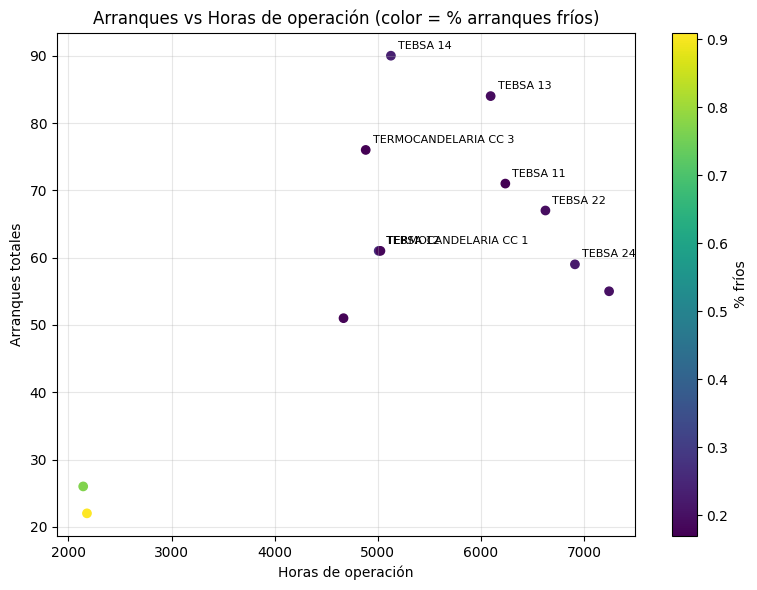

In [14]:
import matplotlib.pyplot as plt

df_sc = df_plot.dropna(subset=["horas_operacion", "arranques_totales"]).copy()

plt.figure(figsize=(8,6))
sc = plt.scatter(
    df_sc["horas_operacion"],
    df_sc["arranques_totales"],
    c=df_sc["pct_frio"].fillna(0),
)

plt.xlabel("Horas de operación")
plt.ylabel("Arranques totales")
plt.title("Arranques vs Horas de operación (color = % arranques fríos)")
plt.grid(True, alpha=0.3)
cbar = plt.colorbar(sc)
cbar.set_label("% fríos")

# (Opcional) Etiquetar top 8 unidades con más arranques
top = df_sc.sort_values("arranques_totales", ascending=False).head(8)
for unidad, row in top.iterrows():
    plt.annotate(
        unidad,
        (row["horas_operacion"], row["arranques_totales"]),
        textcoords="offset points", xytext=(5,5), ha="left", fontsize=8
    )

plt.tight_layout()
plt.show()


## 2) Barras apiladas: Composición térmica de arranques (%)

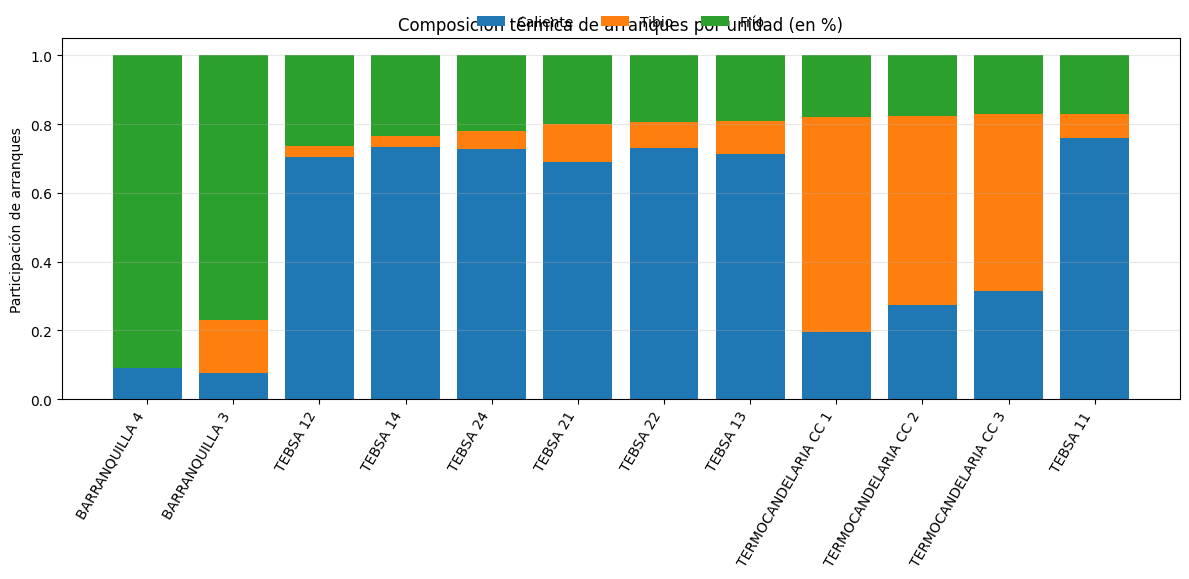

In [15]:
import matplotlib.pyplot as plt

df_st = df_plot.copy()
df_st = df_st[df_st["arranques_totales"] > 0].copy()

# Orden recomendado: por % fríos o por severidad
df_st = df_st.sort_values("pct_frio", ascending=False)

x = np.arange(len(df_st))

plt.figure(figsize=(12,6))
plt.bar(x, df_st["pct_caliente"].fillna(0), label="Caliente")
plt.bar(x, df_st["pct_tibio"].fillna(0), bottom=df_st["pct_caliente"].fillna(0), label="Tibio")
plt.bar(
    x,
    df_st["pct_frio"].fillna(0),
    bottom=(df_st["pct_caliente"].fillna(0) + df_st["pct_tibio"].fillna(0)),
    label="Frío"
)

plt.xticks(x, df_st.index, rotation=60, ha="right")
plt.ylabel("Participación de arranques")
plt.title("Composición térmica de arranques por unidad (en %)")
plt.grid(True, axis="y", alpha=0.3)
plt.legend(ncol=3, frameon=False, loc="upper center", bbox_to_anchor=(0.5, 1.10))
plt.tight_layout()
plt.show()


## 3) Ranking: Severidad promedio (barra)

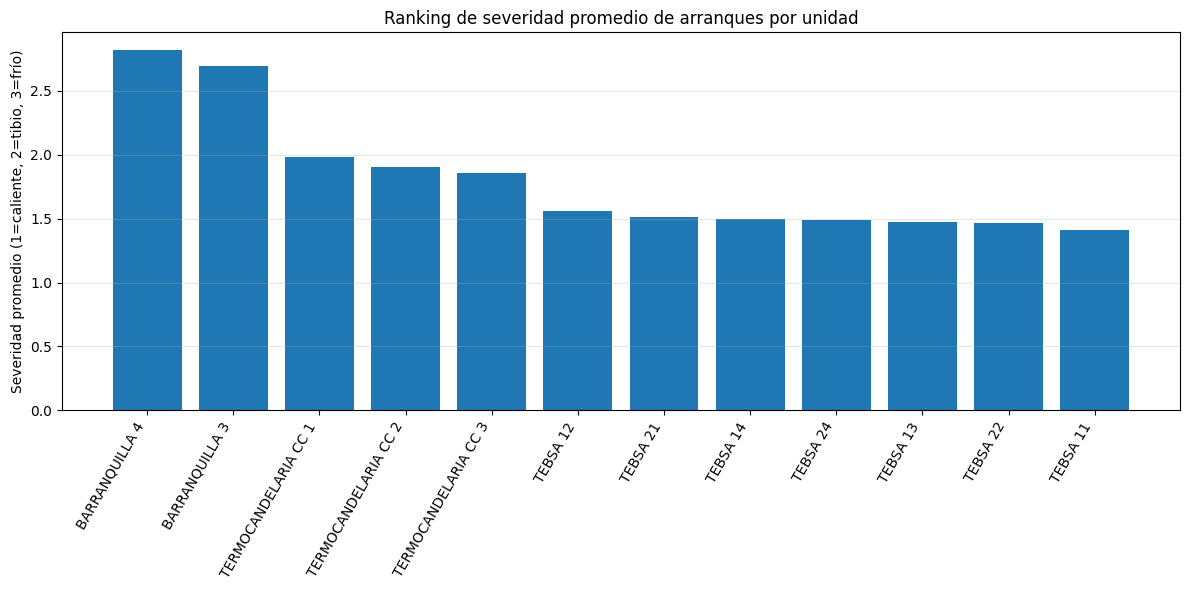

In [16]:
import matplotlib.pyplot as plt

df_sv = df_plot.copy()
df_sv = df_sv[df_sv["arranques_totales"] > 0].copy()
df_sv = df_sv.sort_values("severidad_promedio", ascending=False)

plt.figure(figsize=(12,6))
plt.bar(df_sv.index, df_sv["severidad_promedio"])

plt.xticks(rotation=60, ha="right")
plt.ylabel("Severidad promedio (1=caliente, 2=tibio, 3=frío)")
plt.title("Ranking de severidad promedio de arranques por unidad")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()
